Hemen RS eta IB neuronaren ebazpenak erabiliko dira.

Erabilitako moduloak:

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec

Erabilitako aldagaien laburbilduma:

|Aldagaia|Definizioa|Unitatea|
|--------|-----------|-------|
|$t_{max}$ |Simulazioa denbora maximoa|$ms$|
|$\Delta t$|Denboraren diskretizazioa |$ms$|
|$\tau_{max}$ |Parametro esperimentala|$s$|
|$C_{m}$   |Mintz kapazitatea         |$\frac{\mu F}{cm^{2}}$|
|$E_{Na}$  |Inbertsio potentziala, sodio kanaletarako|$mV$|
|$E_{K}$   |Inbertsio potentziala, potasio kanaletarako|$mV$|
|$E_{L}$   |Inbertsi potentziala|$mV$|
|$E_{Ca}$   |Inbertsi potentziala, kaltzio kanaletarako|$mV$|
|$g_{Na}$  |Konduktantzia espezifikoa, sodio korronte azkarrerako|$\frac{mS}{cm^{2}}$|
|$g_{K}$   |Konduktantzia espezifikoa, potasio korronte iraukorrerako|$\frac{mS}{cm^{2}}$|
|$g_{M}$   |Konduktantzia espezifikoa, potasio korronte geldorako|$\frac{mS}{cm^{2}}$|
|$g_{L}$   |Konduktantzia espezifikoa|$\frac{mS}{cm^{2}}$|
|$g_{Ca}$   |Konduktantzia espezifikoa, kaltzio korronte leherketarako|$\frac{mS}{cm^{2}}$|
|$i_{mean}$|Batez-besteko intentsitate bat finkatu|$\frac{\mu A}{cm^{2}}$|
|$V_{rest}$|Egoera egonkorreko mintz potentziala|$mV$|
|$V_{Th}$|Atari potentziala|$mV$|

In [2]:
#Parametroak finkatu#####
t_max=100      # ms
delta_t=0.04   # ms
tau_max=500.0  # s
C_m=3.14       # micro F/cm^2 (c_m/(L*d)=C_m)
E_Na=50.00     # mV
E_K=-90.00     # mV
E_L=-70.00     # mV
E_Ca=120.0     # mV
g_Na=50.0      # mS/cm^2
g_K=5.0        # mS/cm^2
g_M=0.07       # mS/cm^2
g_L=0.1        # mS/cm^2
g_Ca=0.1       # mS/cm^2  
i_mean=0.5     # microA/cm^2
V_rest=-65.0   # mV
v_th=-40.0     # mV

### Funtzio laguntzaileen inplementazioa

$$\alpha_{m}=\frac{-0.32(v-v_{Th}-13)}{\exp [-(v-v_{Th}-13)/4]-1}$$

$$\beta_{m}=\frac{0.28(v-v_{Th}-40)}{\exp [(v-v_{Th}-40)/5]-1}$$

$$\alpha_{h}=0.128\exp [-(v-v_{Th}-17)/18]$$

$$\beta_{h}=\frac{4}{1+ exp[-(v-v_{Th}-40)/5]}$$

$$\alpha_{n}=\frac{-0.032(v-v_{Th}-15)}{\exp [-(v-v_{Th}-15)/5]-1}$$

$$\beta_{n}=0.5 \exp[-(v-v_{Th}-10)/40]$$

$$p_{\infty}(v)=\frac{1}{1+\exp[-(v+35)/10]}$$

$$\tau_{p}(v)=\frac{\tau_{max}}{3.3\exp[(v+35)/20]+\exp[-(v+35)/20]}$$

$$\alpha_{q}=\frac{0.055(-27-v)}{\exp [(-27-v)/3.9]-1}$$

$$\beta_{q}=0.94 \exp[(-75-v)/17]$$

$$\alpha_{r}=0.000457 \exp[(-13-v)/50]$$

$$\beta_{r}=\frac{0.0065}{1+ exp[(-15-v)/28]}$$

In [3]:
def alpha_m(v):
    return -0.32 * (v - v_th - 13.0) / (np.exp(-(v - v_th - 13.0) / 4.0) - 1.0)

def beta_m(v):
    return 0.28 * (v - v_th - 40.0) / (np.exp((v - v_th - 40.0) / 5.0) - 1.0)

def alpha_h(v):
    return 0.128 * np.exp(-(v - v_th - 17.0)/18.0)

def beta_h(v):
    return 4.0 / (1.0 + np.exp(-(v - v_th - 40.0) / 5.0))

def alpha_n(v):
    return -0.032 * (v - v_th - 15.0) / (np.exp(-(v - v_th - 15.0) / 5.0) - 1.0)

def beta_n(v):
    return 0.5 * np.exp(-(v - v_th - 10.0) / 40.0)

def p_infty(v):
    return 1.0 / (1.0 + np.exp(-(v + 35.0) / 10.0))

def tau_p(v):
    return tau_max / (3.3 * np.exp((v + 35.0) / 20.0) + np.exp(-(v + 35.0) / 20.0))

def alpha_q(v):
    return 0.055 * (-27.0 - v) / (np.exp((-27.0 - v) / 3.8) - 1.0)

def beta_q(v):
    return 0.94 * np.exp((-75.0 - v) / 17.0)

def alpha_r(v):
    return 0.000457 * np.exp((-13.0 - v) / 50.0)

def beta_r(v):
    return 0.0065 / (np.exp((-15.0 - v) / 28.0) + 1.0)

### Bektoreak eta hasierako balioak finkatu

In [4]:
#Denbora eremu osoa finkatzen dugu. 0 s-tik hasiz, delta_t diskretizazio denbora aldiunez t_max aldiunerarte
t_eremua=np.arange(0,t_max,delta_t)
#Luzera finkatu
step=len(t_eremua)

#RS neuronarentzat
Vt_RS=np.ones([step])

#IB neuronarentzat
Vt_IB=np.ones([step])

#RS neuronarentzat
nt_RS=np.ones([step])
mt_RS=np.ones([step])
ht_RS=np.ones([step])
pt_RS=np.ones([step])

#IB neuronarentzat
nt_IB=np.ones([step])
mt_IB=np.ones([step])
ht_IB=np.ones([step])
pt_IB=np.ones([step])
qt=np.ones([step])
rt=np.ones([step])

Haisierako egoerak finkatu aldagai dinamiko guztientzat. Bai RS neuronarako zein IB neuronarako. Intuitiboa den moduan, RS atzizkia RS neuronaren ebazpenerako erabiliko diren objetuak dira. IB atzizkikoak berriz, IB neuronarako.

In [5]:
#RS nuronarentzat
Vt_RS[0]=V_rest
nt_RS[0]= alpha_n(V_rest) / (alpha_n(V_rest) + beta_n(V_rest))
mt_RS[0]= alpha_m(V_rest) / (alpha_m(V_rest) + beta_m(V_rest))
ht_RS[0]= alpha_h(V_rest) / (alpha_h(V_rest) + beta_h(V_rest))
pt_RS[0]= p_infty(V_rest)

#IB neuronarentzat
Vt_IB[0]=V_rest
nt_IB[0]= alpha_n(V_rest) / (alpha_n(V_rest) + beta_n(V_rest))
mt_IB[0]= alpha_m(V_rest) / (alpha_m(V_rest) + beta_m(V_rest))
ht_IB[0]= alpha_h(V_rest) / (alpha_h(V_rest) + beta_h(V_rest))
pt_IB[0]= p_infty(V_rest)
qt[0]= alpha_q(V_rest) / (alpha_q(V_rest) + beta_q(V_rest))
rt[0]= alpha_r(V_rest) / (alpha_r(V_rest) + beta_r(V_rest))

Neurona bakoitzerako bektore bat definituko da. Bektore honen barruko balio bakoitzak intentsitate jakin bakoitzerako zenbat ekintza potentzial gauzatu diren adieraziko digu.

In [6]:
#RS neuronarentzat
Spike_Kont_RS=np.zeros([100]) #Bektoreko balio bakoitzean, intentsitate jakin bati dagokion spike kopurua gordeko da lehenengo 100 segundutan.

#IB neuronanrentzat
Spike_Kont_IB=np.zeros([100]) #Bektoreko balio bakoitzean, intentsitate jakin bati dagokion spike kopurua gordeko da lehenengo 100 segundutan.

11, 16 eta 20. Irudietan jarraitu den estrategia berdina jarraituko da hemen. Vt>0 bada spike-a eman da. kont izeneko integer bat erabiliko da intentsitate bakoitzerako zenbat ekintza potentzial gauzatu diren ikusteko.

Lehenik RS neuronarako:

Euler-en aurrerazko formula erabiliz diskretizazioa denboran egiteko:

$$v^{i+1}=v^{i}+\frac{\Delta t}{C_{m}}[I^{i}-\overline{g_{Na}}(m^{3})^{i}h^{i}(v^{i}-E_{Na})-\overline{g_{K}}(n^{4})^{i}(v^{i}-E_{K})-\overline{g_{M}}p^{i}(v^{i}-E_{K})-\overline{g_{L}}(v^{i}-E_{L})]$$

$$n^{i+1}=n^{i}+\Delta t[\alpha_{n}(v^{i})(1-n^{i})-\beta_{n}(v^{i})n^{i}]$$

$$m^{i+1}=m^{i}+\Delta t[\alpha_{m}(v^{i})(1-m^{i})-\beta_{m}(v^{i})m^{i}]$$

$$h^{i+1}=h^{i}+\Delta t[\alpha_{h}(v^{i})(1-h^{i})-\beta_{h}(v^{i})h^{i}]$$

$$p^{i+1}=p^{i}+\Delta t[\frac{p_{\infty}(v^{i})-p^{i}}{\tau_{p}(v^{i})}]$$

In [7]:
for k in range(0,100):
    j=0
    m=0
    kont=0
    I=i_mean + 0.1*k
    for i in range(0, step-1) :
        mt_RS[i + 1] = mt_RS[i] + delta_t * (alpha_m(Vt_RS[i]) * (1.0 - mt_RS[i]) - beta_m(Vt_RS[i]) * mt_RS[i])
        ht_RS[i + 1] = ht_RS[i] + delta_t * (alpha_h(Vt_RS[i]) * (1.0 - ht_RS[i]) - beta_h(Vt_RS[i]) * ht_RS[i])
        nt_RS[i + 1] = nt_RS[i] + delta_t * (alpha_n(Vt_RS[i]) * (1.0 - nt_RS[i]) - beta_n(Vt_RS[i]) * nt_RS[i])
        pt_RS[i + 1] = pt_RS[i] + delta_t * ((p_infty(Vt_RS[i]) - pt_RS[i]) / tau_p(Vt_RS[i]))
        Vt_RS[i + 1] = Vt_RS[i] + (delta_t/C_m) * (I-g_Na * mt_RS[i] ** 3 * ht_RS[i] * (Vt_RS[i]-E_Na) - g_K * nt_RS[i] ** 4 * (Vt_RS[i]-E_K)- g_M * pt_RS[i] * (Vt_RS[i] - E_K) - g_L * (Vt_RS[i]-E_L))
    
        #Fire-egiteko aldiunea kalkulatu
        if Vt_RS[i+1]>=0.0 and m==0: # Fire egin duela zihurtatu.
            kont=kont+1
            m=1                   # m=1 bihurtu.

        #spike-a-ren amaiera lortu eta parametroak ezarri
        if Vt_RS[i+1]<0.0 and m==1:  # m parametroak berrezarri.
            m=0                   # m=0 berrezarri.
                                  #spike-a amaitu da, m parametroa hasierako egoerara eman
    Spike_Kont_RS[k]=kont*1.0    

Jarraian IB neuronarako: 

$$v^{i+1}=v^{i}+\frac{\Delta t}{C_{m}}[I^{i}-\overline{g_{Na}}(m^{3})^{i}h^{i}(v^{i}-E_{Na})-\overline{g_{K}}(n^{4})^{i}(v^{i}-E_{K})-\overline{g_{M}}p^{i}(v^{i}-E_{K})-\overline{g_{Ca}}(q^{2})^{i}r^{i}(v^{i}-E_{Ca})-\overline{g_{L}}(v^{i}-E_{L})]$$

$$n^{i+1}=n^{i}+\Delta t[\alpha_{n}(v^{i})(1-n^{i})-\beta_{n}(v^{i})n^{i}]$$

$$m^{i+1}=m^{i}+\Delta t[\alpha_{m}(v^{i})(1-m^{i})-\beta_{m}(v^{i})m^{i}]$$

$$h^{i+1}=h^{i}+\Delta t[\alpha_{h}(v^{i})(1-h^{i})-\beta_{h}(v^{i})h^{i}]$$

$$p^{i+1}=p^{i}+\Delta t[\frac{p_{\infty}(v^{i})-p^{i}}{\tau_{p}(v^{i})}]$$

$$q^{i+1}=q^{i}+\Delta t[\alpha_{q}(v^{i})(1-q^{i})-\beta_{q}(v^{i})q^{i}]$$

$$r^{i+1}=r^{i}+\Delta t[\alpha_{r}(v^{i})(1-r^{i})-\beta_{r}(v^{i})r^{i}]$$

In [8]:
for k in range(0,100):
    j=0
    m=0
    kont=0
    I=i_mean + 0.1*k
    for i in range(0, step-1) :
        mt_IB[i + 1] = mt_IB[i] + delta_t * (alpha_m(Vt_IB[i]) * (1.0 - mt_IB[i]) - beta_m(Vt_IB[i]) * mt_IB[i])
        ht_IB[i + 1] = ht_IB[i] + delta_t * (alpha_h(Vt_IB[i]) * (1.0 - ht_IB[i]) - beta_h(Vt_IB[i]) * ht_IB[i])
        nt_IB[i + 1] = nt_IB[i] + delta_t * (alpha_n(Vt_IB[i]) * (1.0 - nt_IB[i]) - beta_n(Vt_IB[i]) * nt_IB[i])
        pt_IB[i + 1] = pt_IB[i] + delta_t * ((p_infty(Vt_IB[i]) - pt_IB[i]) / tau_p(Vt_IB[i]))
        qt[i + 1] = qt[i] + delta_t * (alpha_q(Vt_IB[i]) * (1.0 - qt[i]) - beta_q(Vt_IB[i]) * qt[i])
        rt[i + 1] = rt[i] + delta_t * (alpha_r(Vt_IB[i]) * (1.0 - rt[i]) - beta_r(Vt_IB[i]) * rt[i])
        Vt_IB[i + 1] = Vt_IB[i] + (delta_t/C_m) * (I-g_Na * mt_IB[i] ** 3 * ht_IB[i] * (Vt_IB[i]-E_Na) - g_K * nt_IB[i] ** 4 * (Vt_IB[i]-E_K)- g_Ca * qt[i]** 2 * rt[i] * (Vt_IB[i] - E_Ca) - g_M * pt_IB[i] * (Vt_IB[i] - E_K) - g_L * (Vt_IB[i]-E_L)) 
        
        #Fire-egiteko aldiunea kalkulatu
        if Vt_IB[i+1]>=0.0 and m==0: # Fire egin duela zihurtatu.
            kont=kont+1
            m=1                   # m=1 bihurtu.

        #spike-a-ren amaiera lortu eta parametroak ezarri
        if Vt_IB[i+1]<0.0 and m==1:  # m parametroak berrezarri.
            m=0                   # m=0 berrezarri.
                                  #spike-a amaitu da, m parametroa hasierako egoerara eman
    Spike_Kont_IB[k]=kont*1.0 

Intentsitatea irudikatzeko bektore bat sortu.

In [9]:
Inten=np.ones([100])
for i in range(0,100):
    Inten[i]= i_mean + i*0.1

Ploteatu

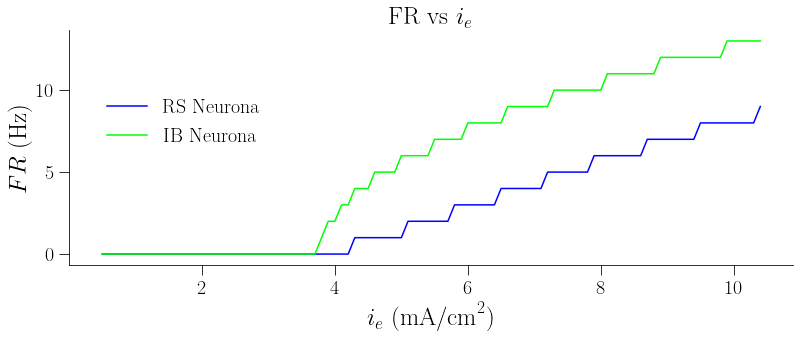

In [10]:
#################################  ### 00 ###

plt.rc('text', usetex=True)

#################################
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

#################################  ### 01 ###
fontsize = 25
labelsize = 20
#################################


fig = plt.figure(constrained_layout=True, figsize=(11,8))

spec = gridspec.GridSpec(ncols=1, nrows=2, figure=fig)
f_ax1 = fig.add_subplot(spec[0, 0])
f_ax1.plot(Inten, Spike_Kont_RS , 'b', label= r"$\textrm{RS Neurona}$")
f_ax1.plot(Inten, Spike_Kont_IB , 'lime', label= r"$\textrm{IB Neurona}$")


f_ax1.set_xlabel(r'$i_{e} \textrm{ (mA/cm}^{2})$', fontsize=fontsize)
f_ax1.set_ylabel(r'$FR \textrm{ (Hz)}$',fontsize=fontsize)
f_ax1.set_title(r'$\textrm{FR vs } i_{e}$',fontsize=fontsize)

f_ax1.legend(bbox_transform=f_ax1.transData, bbox_to_anchor=(3, 10), ncol=1, borderaxespad=0, 
             frameon=False, fontsize=20)
axes_fig = [f_ax1] # irudiak dazkanaren arabera

for i in axes_fig:
    i.tick_params(axis='y', labelsize=labelsize, pad=5, length=10);
    i.tick_params(axis='x', labelsize=labelsize, pad=5, length=10);


plt.savefig('Fire Kopurua 100ms-ro vs I.pdf', format='pdf', dpi=180,bbox_inches="tight")